In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import os
from google.colab import files

import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications import VGG19


from keras.models import Model, load_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# {"username":"miguelgallego","key":"6a7a2546d0b0a5683db1abd67fc0380c"}
dataset_link = "https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: miguelgallego
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [00:28<00:00, 63.4MB/s]


In [4]:
# Ruta de la carpeta principal del conjunto de datos
dataset_dir = "/content/food-image-classification-dataset/Food Classification dataset"

# Lista de carpetas dentro de la carpeta principal
subdirectories = os.listdir(dataset_dir)
print("Contenido de la carpeta principal:")
print(subdirectories)

Contenido de la carpeta principal:
['pizza', 'jalebi', 'fried_rice', 'dhokla', 'idli', 'pakode', 'omelette', 'chole_bhature', 'chicken_curry', 'samosa', 'pav_bhaji', 'chai', 'chapati', 'Taco', 'Fries', 'burger', 'ice_cream', 'Baked Potato', 'Crispy Chicken', 'kulfi', 'masala_dosa', 'Sandwich', 'Donut', 'butter_naan', 'sushi', 'Hot Dog', 'momos', 'apple_pie', 'paani_puri', 'kaathi_rolls', 'dal_makhani', 'Taquito', 'cheesecake', 'kadai_paneer']


In [5]:
# Lista de clases de alimentos
classes = subdirectories
num_classes = len(classes)
print(f'Número de clases {num_classes}')

Número de clases 34


In [6]:
# Directorio raíz del conjunto de datos
dataset_root = "/content/food-image-classification-dataset/Food Classification dataset"

# # Muestra ejemplos de imágenes de cada clase
# num_examples_per_class = 3
# for food_class in classes:
#     class_dir = os.path.join(dataset_root, food_class)
#     image_files = os.listdir(class_dir)
#     random.shuffle(image_files)  # Baraja las imágenes para mostrar ejemplos aleatorios
#     plt.figure(figsize=(12, 4))
#     for i in range(num_examples_per_class):
#         img_path = os.path.join(class_dir, image_files[i])
#         img = Image.open(img_path)
#         plt.subplot(1, num_examples_per_class, i + 1)
#         plt.imshow(img)
#         plt.title(food_class)
#     plt.show()


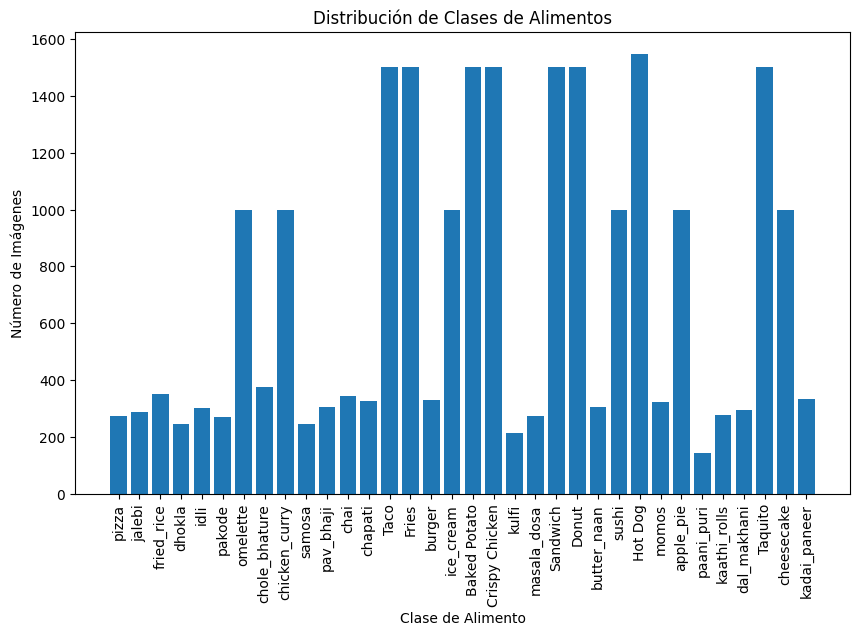


Número total de imágen: 23873


In [7]:
# Calcula el número de imágenes por clase
num_images_per_class = {food_class: len(os.listdir(os.path.join(dataset_root, food_class))) for food_class in classes}

# Muestra la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(num_images_per_class.keys(), num_images_per_class.values())
plt.xlabel('Clase de Alimento')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Clases de Alimentos')
plt.xticks(rotation=90)
plt.show()

n_images = sum(num_images_per_class.values())
print(f"\nNúmero total de imágen: {n_images}")

In [8]:
# Calcula el número de imágenes por clase
num_images_per_class = {food_class: len(os.listdir(os.path.join(dataset_root, food_class))) for food_class in classes}
num_images_per_class

{'pizza': 275,
 'jalebi': 288,
 'fried_rice': 350,
 'dhokla': 245,
 'idli': 302,
 'pakode': 269,
 'omelette': 1000,
 'chole_bhature': 376,
 'chicken_curry': 1000,
 'samosa': 244,
 'pav_bhaji': 305,
 'chai': 344,
 'chapati': 327,
 'Taco': 1500,
 'Fries': 1500,
 'burger': 331,
 'ice_cream': 1000,
 'Baked Potato': 1500,
 'Crispy Chicken': 1500,
 'kulfi': 214,
 'masala_dosa': 273,
 'Sandwich': 1500,
 'Donut': 1500,
 'butter_naan': 307,
 'sushi': 1000,
 'Hot Dog': 1548,
 'momos': 323,
 'apple_pie': 1000,
 'paani_puri': 144,
 'kaathi_rolls': 279,
 'dal_makhani': 295,
 'Taquito': 1500,
 'cheesecake': 1000,
 'kadai_paneer': 334}

In [9]:
# Obtiene las dimensiones de una imagen de muestra
random_class = random.choice(classes)
random_img = random.choice(os.listdir(os.path.join(dataset_root,random_class)))
sample_image_path = os.path.join(dataset_root, random_class, random_img)
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
print(f"Ancho de imagen: {image_width}px, Alto de imagen: {image_height}px")


Ancho de imagen: 1024px, Alto de imagen: 700px


In [10]:
# Redimensionado de las imágenes
target_size = (224, 224)  # Tamaño deseado de las imágenes

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.LANCZOS)  # Redimensionar la imagen
    # Realizar otras transformaciones, como normalización de píxeles, aquí si es necesario?
    return image

In [11]:
# Inicializa listas para almacenar las rutas de imágenes y etiquetas
image_paths = []
labels = []

# Itera a través de las carpetas de clases de alimentos
for food_class in subdirectories:
    class_dir = os.path.join(dataset_dir, food_class)
    if os.path.isdir(class_dir):
        # Enumera los archivos de imágenes en la carpeta de la clase
        class_image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
        # Agrega las rutas de imágenes a la lista
        image_paths.extend(class_image_paths)
        # Agrega las etiquetas correspondientes (nombre de la clase) a la lista
        labels.extend([food_class] * len(class_image_paths))

In [12]:
# Crear un DataFrame con las rutas de las imágenes y las etiquetas
data = {'filename': image_paths, 'class': labels}
df = pd.DataFrame(data)
df.groupby('class').count()

,filename
class,
Baked Potato,1500
Crispy Chicken,1500
Donut,1500
Fries,1500
Hot Dog,1548
Sandwich,1500
Taco,1500
Taquito,1500
apple_pie,1000


In [13]:
desired_min_samples = 800
desired_max_samples = 250

# Lista de clases con más de 800 y menos de 250 muestras
df_classes = df['class'].value_counts()

overpopulated_classes = df_classes[df_classes > desired_min_samples].index.tolist()
underpopulated_classes = df_classes[df_classes < desired_max_samples].index.tolist()

# Crear un nuevo conjunto de datos balanceado
new_data = []

for i_class in overpopulated_classes:
    # Filtra las muestras de la clase actual
    actual_class = df[df['class'] == i_class]

    # Selecciona aleatoriamente 800 muestras de la clase actual
    selected_samples = actual_class.sample(n=desired_min_samples, random_state=42)

    # Agrega las muestras seleccionadas al nuevo conjunto de datos
    new_data.append(selected_samples)

# Concatena los datos de todas las clases seleccionadas
clipped_data = pd.concat(new_data)

# Conjunto de datos con 800 muestras por cada clase en overpopulated_classes
clipped_data.groupby('class').count()

,filename
class,
Baked Potato,800
Crispy Chicken,800
Donut,800
Fries,800
Hot Dog,800
Sandwich,800
Taco,800
Taquito,800
apple_pie,800


In [14]:
underpopulated_classes

['dhokla', 'samosa', 'kulfi', 'paani_puri']

In [15]:
# Elimina las filas correspondientes a estas clases del DataFrame original (<250 y >800)
data_to_incrase = df[~df['class'].isin(underpopulated_classes)]
data_to_incrase = data_to_incrase[~data_to_incrase['class'].isin(overpopulated_classes)]

# Clases con menos de 800 muestras y más de 250 muestras.
data_to_incrase.groupby('class').count()

,filename
class,
burger,331
butter_naan,307
chai,344
chapati,327
chole_bhature,376
dal_makhani,295
fried_rice,350
idli,302
jalebi,288


In [16]:
# Dataset filtrado
filtered_data = pd.concat([clipped_data, data_to_incrase])
filtered_data.groupby('class').count()

,filename
class,
Baked Potato,800
Crispy Chicken,800
Donut,800
Fries,800
Hot Dog,800
Sandwich,800
Taco,800
Taquito,800
apple_pie,800


In [17]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Carga la imagen desde la ruta
    img = Image.open(image_path)

    # Redimensiona la imagen al tamaño objetivo
    img = img.resize(target_size)

    # Convierte la imagen en un array numpy
    img_array = np.array(img)

    # Normaliza los valores de píxeles al rango [0, 1]
    img_array = img_array / 255.0

    return img_array

In [18]:
# from keras.preprocessing.image import ImageDataGenerator

# # Define el generador de datos para aumentar las muestras
# augmentation_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Encuentra las clases con menos de 800 muestras
# classes_below_800 = filtered_data['class'].value_counts()
# classes_below_800 = classes_below_800[classes_below_800 < 800].index.tolist()

# # Crea un DataFrame para almacenar las muestras generadas
# augmented_data = pd.DataFrame(columns=['filename', 'class'])

# # Define el tamaño del lote
# batch_size = 10

# # Itera sobre las clases con menos de 800 muestras
# for class_name in classes_below_800:
#     # Filtra las muestras de la clase actual
#     class_df = filtered_data[filtered_data['class'] == class_name]

#     # Calcula cuántas muestras adicionales se necesitan
#     samples_needed = 800 - len(class_df)

#     # Crea una lista para almacenar las imágenes
#     images = []

#     # Itera sobre las rutas de las imágenes y carga cada imagen
#     for image_path in class_df['filename']:
#         img = load_and_preprocess_image(image_path)
#         images.append(img)

#     # Genera muestras adicionales utilizando el ImageDataGenerator
#     augmented_images = []

#     for _ in range(samples_needed):
#         augmented_samples = []
#         for img in images:
#             augmented_image = augmentation_datagen.random_transform(img)
#             augmented_samples.append(augmented_image)
#         augmented_images.append(augmented_samples)

#     # Agrega las nuevas muestras al DataFrame
#     new_samples_df = pd.DataFrame({'filename': augmented_images, 'class': [class_name] * samples_needed})
#     augmented_data = pd.concat([augmented_data, new_samples_df], ignore_index=True)

# # Concatena las muestras generadas con el DataFrame original
# balanced_data = pd.concat([filtered_data, augmented_data])

# # Verifica que todas las clases ahora tengan 800 muestras
# balanced_data.groupby('class').count()


In [19]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

# Define el generador de datos para aumentar las muestras
augmentation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Encuentra las clases con menos de 800 muestras
classes_below_800 = filtered_data['class'].value_counts()
classes_below_800 = classes_below_800[classes_below_800 < 800].index.tolist()

# Crea un DataFrame para almacenar las muestras generadas
augmented_data = pd.DataFrame(columns=['filename', 'class'])

# Define el tamaño del lote
batch_size = 24

# Itera sobre las clases con menos de 800 muestras
for class_name in classes_below_800:
    # Filtra las muestras de la clase actual
    class_df = filtered_data[filtered_data['class'] == class_name]

    # Calcula cuántas muestras adicionales se necesitan
    samples_needed = 800 - len(class_df)

    # Convierte las imágenes en un array numpy
    images = [load_and_preprocess_image(image_path) for image_path in class_df['filename']]

    # Genera muestras adicionales en lotes
    num_batches = samples_needed // batch_size
    for batch in range(num_batches):
        augmented_images = []
        for i in range(batch_size):
            augmented_image = augmentation_datagen.random_transform(images[i])
            augmented_images.append(augmented_image)
        augmented_samples_df = pd.DataFrame({'filename': augmented_images, 'class': [class_name] * batch_size})
        augmented_data = pd.concat([augmented_data, augmented_samples_df], ignore_index=True)

# Concatena las muestras generadas con el DataFrame original
balanced_data = pd.concat([filtered_data, augmented_data])

# Verifica que todas las clases ahora tengan 800 muestras
balanced_data.groupby('class').count()

# Guarda el DataFrame con los datos generados en un archivo CSV
balanced_data.to_csv('balanced_data.csv', index=False)

In [ ]:
# Carga el DataFrame desde el archivo CSV
balanced_data = pd.read_csv('balanced_data.csv')

In [ ]:
# Dividir los datos en entrenamiento (70%) y temporales (30%)
train_data, temp_data = train_test_split(balanced_data, test_size=0.3, random_state=42)

# Dividir los datos temporales en validación (50%) y prueba (50%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
# from keras.utils import Sequence

# class CustomDataGenerator(Sequence):
#     def __init__(self, data, batch_size, augmentation_datagen):
#         self.data = data
#         self.batch_size = batch_size
#         self.augmentation_datagen = augmentation_datagen

#     def __len__(self):
#         return len(self.data) // self.batch_size

#     def __getitem__(self, index):
#         batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]

#         # Convierte las imágenes en un array numpy
#         images = [load_and_preprocess_image(image_path) for image_path in batch_data['filename']]
#         images = np.array(images)

#         # Aplica aumentos de datos al lote
#         augmented_images = []
#         for i in range(self.batch_size):
#             augmented_image = self.augmentation_datagen.random_transform(images[i])
#             augmented_images.append(augmented_image)

#         return np.array(augmented_images), to_categorical(batch_data['class'], num_classes=num_classes)

# # Crear un generador de datos personalizado para el entrenamiento
# train_generator = CustomDataGenerator(data=train_data, batch_size=batch_size, augmentation_datagen=augmentation_datagen)
# validation_generator = CustomDataGenerator(data=validation_data, batch_size=batch_size, augmentation_datagen=augmentation_datagen)
# test_generator = CustomDataGenerator(data=test_data, batch_size=batch_size, augmentation_datagen=augmentation_datagen)

# # # Entrenar el modelo usando train_generator
# # model.fit(train_generator, epochs=epochs)


In [ ]:
import keras
# Crea y define el ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalizar los valores de píxeles al rango [0, 1]
    preprocessing_function=keras.applications.vgg19.preprocess_input # imagenes rgb a bgr
    # rotation_range=20,      # Rango de rotación aleatoria
    # width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    # height_shift_range=0.2, # Desplazamiento vertical aleatorio
    # shear_range=0.2,        # Distorsión de corte aleatoria
    # zoom_range=0.2,         # Ampliación aleatoria
    # horizontal_flip=True,   # Volteo horizontal aleatorio
    # fill_mode='nearest'     # Estrategia de relleno
)

batch_size = 32

# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow_from_dataframe(
    dataframe = train_data,
    target_size=(224, 224),  # Ajusta el tamaño según tu modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = validation_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de validación
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de prueba
)

images, img_labels = next(train_generator)
print("Forma del lote de imágenes:", images.shape)

Found 11351 validated image filenames belonging to 30 classes.
Found 2368 validated image filenames belonging to 30 classes.
Found 2459 validated image filenames belonging to 30 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5299 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1200 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1109 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Forma del lote de imágenes: (32, 224, 224, 3)


Forma del lote de imágenes: (32, 224, 224, 3)


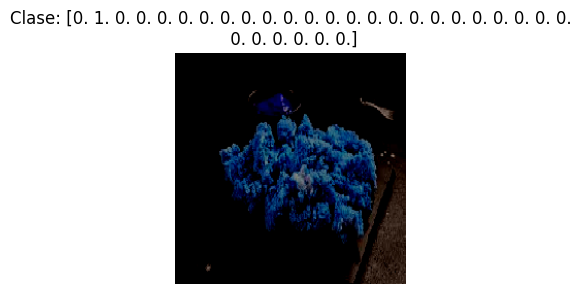

In [ ]:
# Tomar un lote de imágenes del generador
images, img_labels = next(train_generator)

# Verificar las formas de las imágenes en el lote
print("Forma del lote de imágenes:", images.shape)  # Debería ser (batch_size, height, width, channels)

# Seleccionar una imagen del lote (por ejemplo, la primera imagen)
image = images[0]  # Cambia el índice si se desea visualizar otra imagen

# Mostrar la imagen utilizando Matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(image.squeeze())  # Asegúrate de usar 'gray' para imágenes en escala de grises
plt.axis('off')  # Deshabilita los ejes
plt.title(f'Clase: {img_labels[0]}')  # Muestra la etiqueta de clase (cambia si no usas one-hot encoding)
plt.show()


In [ ]:
# Cargar y visualizar modelo preentrenado
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.summary()

In [ ]:
# Número de clases que serviran a la última capa de salida
classes_number = balanced_data['class'].value_counts().count()

# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para datos
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(classes_number, activation='softmax')(x)

# Crea un nuevo modelo con la capa de salida modificada
new_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compila el modelo
new_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Entrenar el modelo utilizando los generadores de datos
epochs = 50  # Número de épocas
history = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Número total de lotes por época
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Número total de lotes de validación por época
)

Epoch 1/50
354/354 [==============================] - 102s 284ms/step - loss: 0.0990 - accuracy: 0.9678 - val_loss: 2.8504 - val_accuracy: 0.6178
Epoch 2/50
354/354 [==============================] - 102s 288ms/step - loss: 0.0722 - accuracy: 0.9777 - val_loss: 3.4621 - val_accuracy: 0.5790
Epoch 3/50
354/354 [==============================] - 101s 286ms/step - loss: 0.0734 - accuracy: 0.9774 - val_loss: 3.7580 - val_accuracy: 0.5633
Epoch 4/50
354/354 [==============================] - 101s 285ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 4.2791 - val_accuracy: 0.5389
Epoch 5/50
354/354 [==============================] - 101s 284ms/step - loss: 0.0663 - accuracy: 0.9767 - val_loss: 3.4509 - val_accuracy: 0.6047
Epoch 6/50
354/354 [==============================] - 101s 286ms/step - loss: 0.0780 - accuracy: 0.9759 - val_loss: 4.2593 - val_accuracy: 0.5950
Epoch 7/50
354/354 [==============================] - 101s 286ms/step - loss: 0.0717 - accuracy: 0.9784 - val_loss: 4.4590 -

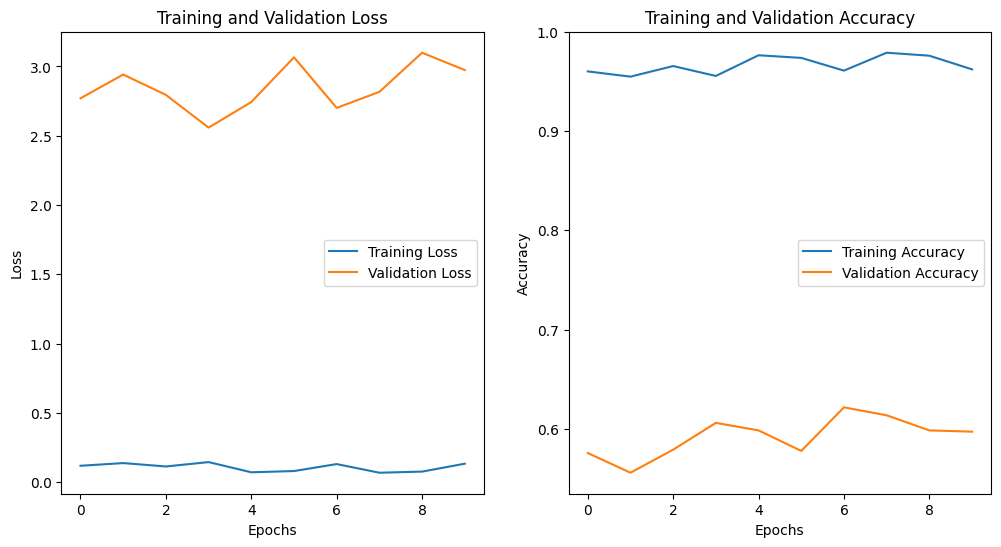

In [ ]:
import matplotlib.pyplot as plt

# Get the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()


In [ ]:
# Guarda el modelo entrenado
new_model.save('second_model_version.h5')
new_model.save('my_second_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Descarga el modelo entrenado
files.download('second_model_version.h5')
files.download('my_second_model.keras')

In [ ]:
# Cargar el modelo
new_model = load_model('/content/second_model_version.h5')

In [ ]:
# Obtiene perdida y precisión en el conjunto de prueba
test_loss, test_accuracy = new_model.evaluate(validation_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

74/74 [==============================] - 19s 257ms/step - loss: 4.0768 - accuracy: 0.4337
Pérdida en el conjunto de prueba: 4.076796054840088
Precisión en el conjunto de prueba: 0.4336993098258972


77/77 [==============================] - 26s 336ms/step
Matriz de Confusión:
[[18 13  6  0  1  1  7  2 13  0 10  0  0  3  3  0  0  3  1  1  0  0  0  0
   0  8 12  0  3 32]
 [ 1 40  3  2  0  1  3  1  4  0  0  0  0  4  0  0  0  2  4  0  0  0  2  0
   0  1 38  0  0  5]
 [ 0  3 69  0  2  2  0  0  6  0  0  0  0  9  0  0  0  0  4  2  0  0  1  0
   0  0  4  0  0 11]
 [ 0  4  0 81  1  1  4  2  4  0  0  0  0  3  2  0  0  1  5  0  0  0  1  0
   0  0  5  0  0  3]
 [ 0  2  2  4 46  4 12  7  3  1  0  0  0 11  1  0  0  0  4  0  0  0  0  0
   1  0  1  0  0 14]
 [ 0 11  1  4  4 51  4  5 11  2  1  0  0 20  0  0  0  0  4  0  0  0  0  0
   0  1  2  0  1  8]
 [ 2  9  5  5  7  1 60  4  7  0  1  1  0  2  3  0  0  1  4  0  0  0  0  0
   1  0  5  0  0 10]
 [ 0 11  2  3  1  1  7 40  4  0  1  0  0  1  6  0  0  0  5  0  0  0  0  0
   1  4  9  0  0 30]
 [ 0  1  1  0  1  0  2  0 65  0  0  0  0 20  6  0  0  0  9  0  0  0  0  0
   0  2  2  0  1 13]
 [ 0  2  1  0  3  6  2  1  2 25  0  0  0  7  0  0  0  0  3  0  0  0 

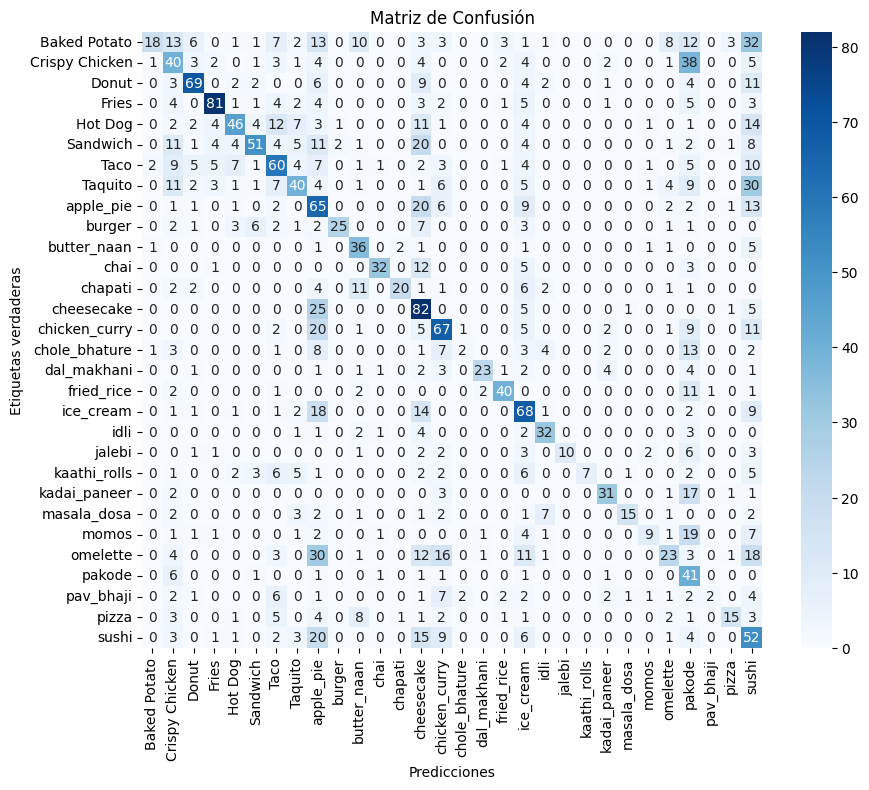

In [ ]:
# Predicciones del modelo en el conjunto de datos de prueba
predictions = new_model.predict(test_generator)
# Convierte las predicciones en etiquetas de clase (por ejemplo, utilizando np.argmax)
predicted_classes = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
true_classes = test_generator.classes
confusion = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(confusion)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Generar un informe de clasificación
class_labels = list(test_generator.class_indices.keys())
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Informe de Clasificación:\n", class_report)

Informe de Clasificación:
                 precision    recall  f1-score   support

  Baked Potato       0.78      0.13      0.23       137
Crispy Chicken       0.31      0.36      0.33       111
         Donut       0.71      0.61      0.66       113
         Fries       0.79      0.69      0.74       117
       Hot Dog       0.65      0.41      0.50       113
      Sandwich       0.71      0.39      0.50       130
          Taco       0.47      0.47      0.47       128
       Taquito       0.52      0.32      0.39       126
     apple_pie       0.25      0.53      0.34       123
        burger       0.89      0.46      0.61        54
   butter_naan       0.47      0.73      0.57        49
          chai       0.86      0.60      0.71        53
       chapati       0.87      0.39      0.54        51
    cheesecake       0.35      0.69      0.46       119
 chicken_curry       0.47      0.54      0.50       124
 chole_bhature       0.40      0.04      0.08        47
   dal_makhani      